# Imports

In [1]:
import sys
import pandas as pd
import os
from tqdm import tqdm

from influxdb_client import InfluxDBClient, Point, WritePrecision
from influxdb_client.client.write_api import SYNCHRONOUS
from dotenv import dotenv_values
import warnings
from influxdb_client.client.warnings import MissingPivotFunction

warnings.simplefilter("ignore", MissingPivotFunction)

# Defines

In [2]:
token = dotenv_values("../../.env.local")['INFLUXDB_TOKEN']
org = "my-org"
bucket = "bucket-session-key"
url = "http://localhost:8086"

In [3]:
client = InfluxDBClient(url=url, token=token, org=org, timeout=60_000 * 2)
query_api = client.query_api()

# sql query

In [5]:
third_query = f"""
    SELECT  
        TS.compound AS CompostoPneu,
        AVG(WC.track_temperature)::NUMERIC(8,2) AS TemperaturaMediaPista,
        MAX(TS.lap_end - TS.lap_start) AS MaxLapDurationTyre
    FROM tyre_stints AS TS
    INNER JOIN weather_conditions AS WC ON WC.session_key = TS.session_key
    GROUP BY TS.compound
    ORDER BY MaxLapDurationTyre DESC
"""

# raw data

In [6]:
query = """
tyreData = from(bucket: "bucket-session-key")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "tyre_stints")
  |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
  |> map(fn: (r) => ({ r with lap_duration: float(v: r.lap_end) - float(v: r.lap_start) }))


weatherData = from(bucket: "bucket-session-key")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "weather_conditions" and r._field == "track_temperature")
  |> keep(columns: ["_time", "session_key", "_value"])
  |> rename(columns: {_value: "track_temperature"})

joined = join(
  tables: {tyre: tyreData, weather: weatherData},
  on: ["session_key"]
)

joined
  |> group(columns: ["compound"])
  |> reduce(
    identity: {count: 0.0, temp_sum: 0.0, max_lap: 0.0, compound: ""},
    fn: (r, accumulator) => ({
      count: accumulator.count + 1.0,
      temp_sum: accumulator.temp_sum + r.track_temperature,
      max_lap: if r.lap_duration > accumulator.max_lap then r.lap_duration else accumulator.max_lap,
      compound: r.compound
    })
  )
  |> map(fn: (r) => ({
    CompostoPneu: r.compound,
    TemperaturaMediaPista: r.temp_sum / r.count,
    MaxLapDurationTyre: r.max_lap
  }))
  |> sort(columns: ["MaxLapDurationTyre"], desc: true)
"""

try:
    df = query_api.query_data_frame(query=query)
    if isinstance(df, list):
        df = pd.concat(df, ignore_index=True)
except Exception as e:
    print(f"Erro ao executar a consulta: {e}")

In [7]:
df

,result,table,CompostoPneu,TemperaturaMediaPista,MaxLapDurationTyre
0,_result,0,HARD,37.730272,55.0
1,_result,0,MEDIUM,37.951413,54.0
2,_result,0,SOFT,36.607010,28.0
3,_result,0,INTERMEDIATE,21.812635,25.0
4,_result,0,WET,25.267131,16.0
5,_result,0,UNKNOWN,33.745252,13.0
6,_result,0,TEST_UNKNOWN,38.309466,12.0


# New format

In [4]:
df_tyre_strints = pd.read_parquet("../../data/stints/stints.parquet").dropna()
df_tyre_strints = df_tyre_strints.drop(columns=["meeting_key"])
df_tyre_strints = df_tyre_strints.drop_duplicates(subset=["session_key", "stint_number", "driver_number"])

In [5]:
df_weather = pd.read_parquet("../../data/weather_conditions/weather_conditions.parquet").dropna()
df_session = pd.read_parquet("../../data/sessions/sessions.parquet")
df_weather = df_weather.drop(columns=["meeting_key"])
df_weather = df_weather.drop_duplicates(subset=["session_key", "date"])
df_weather = df_weather[df_weather["session_key"].isin(df_session["session_key"].to_list())]
df_weather["rainfall"] = df_weather["rainfall"].astype(bool)

In [6]:
df_query = pd.merge(df_tyre_strints, df_weather, on="session_key", how="left")

In [ ]:
write_api = client.write_api(write_options=SYNCHRONOUS)

for _, row in tqdm(df_query.iterrows(), total=len(df_query)):
    point = (
        Point("query3")
        .tag("session_key", str(row["session_key"]))
        .tag("compound", str(row["compound"]))
        .tag("driver_number", str(row["driver_number"]))
        .field("stint_number", int(row["stint_number"]))
        .field("tyre_age_at_start", float(row["tyre_age_at_start"]))
        .field("lap_start", int(row["lap_start"]))
        .field("lap_end", int(row["lap_end"]))
        .field("track_temperature", float(row["track_temperature"]))
        .field("wind_speed", float(row["wind_speed"]))
        .field("rainfall", int(row["rainfall"]))  
        .field("humidity", float(row["humidity"]))
        .field("pressure", float(row["pressure"]))
        .field("air_temperature", float(row["air_temperature"]))
        .field("wind_direction", float(row["wind_direction"])) 
        .time(row["date"], WritePrecision.NS)
    )
    write_api.write(bucket=bucket, org=org, record=point)

  0%|          | 0/597888 [00:00<?, ?it/s]

100%|██████████| 597888/597888 [1:56:29<00:00, 85.54it/s]  


In [8]:
write_api = client.write_api(write_options=SYNCHRONOUS)

for _, row in tqdm(df_query.iterrows(), total=len(df_query)):
    point = (
        Point("query3_compund")
        .tag("compound", str(row["compound"]))
        .tag("session_key", str(row["session_key"]))
        .tag("driver_number", str(row["driver_number"]))
        .field("stint_number", int(row["stint_number"]))
        .field("tyre_age_at_start", float(row["tyre_age_at_start"]))
        .field("lap_start", int(row["lap_start"]))
        .field("lap_end", int(row["lap_end"]))
        .field("track_temperature", float(row["track_temperature"]))
        .field("wind_speed", float(row["wind_speed"]))
        .field("rainfall", int(row["rainfall"]))  
        .field("humidity", float(row["humidity"]))
        .field("pressure", float(row["pressure"]))
        .field("air_temperature", float(row["air_temperature"]))
        .field("wind_direction", float(row["wind_direction"])) 
        .time(row["date"], WritePrecision.NS)
    )
    write_api.write(bucket=bucket, org=org, record=point)

100%|██████████| 650265/650265 [1:32:38<00:00, 116.99it/s] 


In [14]:
query = """
from(bucket: "bucket-session-key")
  |> range(start: 0)
  |> filter(fn: (r) => r._measurement == "query3")
  |> pivot(
      rowKey: ["_time"], 
      columnKey: ["_field"], 
      valueColumn: "_value"
  )
  |> map(fn: (r) => ({
      r with
      lap_duration: float(v: r.lap_end - r.lap_start)
  }))
  |> group(columns: ["compound"])
  |> reduce(
      identity: {count: 0.0, temp_sum: 0.0, max_lap: 0.0, compound: ""},
      fn: (r, accumulator) => ({
          count: accumulator.count + 1.0,
          temp_sum: accumulator.temp_sum + r.track_temperature,
          max_lap: if r.lap_duration > accumulator.max_lap then r.lap_duration else accumulator.max_lap,
          compound: r.compound
      })
  )
  |> map(fn: (r) => ({
      CompostoPneu: r.compound,
      TemperaturaMediaPista: r.temp_sum / r.count,
      MaxLapDurationTyre: r.max_lap
  }))
  |> sort(columns: ["MaxLapDurationTyre"], desc: true)
"""

try:
    df = query_api.query_data_frame(query=query)
    if isinstance(df, list):
        df = pd.concat(df, ignore_index=True)
except Exception as e:
    print(f"Erro ao executar a consulta: {e}")

In [ ]:
df

,result,table,MaxLapDurationTyre,CompostoPneu,TemperaturaMediaPista
0,_result,0,55.0,HARD,36.624775
1,_result,0,54.0,MEDIUM,37.160920
2,_result,0,28.0,SOFT,36.227604
3,_result,0,25.0,INTERMEDIATE,24.453862
4,_result,0,16.0,WET,26.181012
5,_result,0,13.0,UNKNOWN,33.457454
6,_result,0,12.0,TEST_UNKNOWN,38.288612


# Resultos

In [21]:
import numpy as np

def get_statistics(durations):
    """
    Calculate the mean and standard deviation of a list of durations.
    """
    mean = np.mean(durations)
    median = np.median(durations)
    std = np.std(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    print(f"Mean: {mean:.6f} s")
    print(f"Median: {median:.6f} s")
    print(f"Std Dev: {std:.6f} s")
    print(f"Min: {min_duration:.6f} s")
    print(f"Max: {max_duration:.6f} s")

In [22]:
results_raw_data = [
    27.54,
    27.64,
    27.32,
    26.73,
    26.73,
    27.71,
    27.93,
    27.12,
    27.31,
    27.26,
]

In [23]:
get_statistics(results_raw_data)

Mean: 27.329000 s
Median: 27.315000 s
Std Dev: 0.376044 s
Min: 26.730000 s
Max: 27.930000 s


In [11]:
results_new_format_session_key = [
    13.89,
    14.89,
    15.27,
    13.80,
    15.06,
    13.48,
    15.73,
    15.39,
    14.45,
    14.27,
    15.32,
]

In [24]:
get_statistics(results_new_format_session_key)

Mean: 14.686364 s
Median: 14.890000 s
Std Dev: 0.714261 s
Min: 13.480000 s
Max: 15.730000 s


In [12]:
results_new_format_compund = [
    16.61,
    16.63,
    16.09,
    16.20,
    17.15,
    17.04,
    16.72,
    16.70,
    16.12,
    18.22,
]

In [25]:
get_statistics(results_new_format_compund)

Mean: 16.748000 s
Median: 16.665000 s
Std Dev: 0.598110 s
Min: 16.090000 s
Max: 18.220000 s


In [17]:
best_results_postgres = [
    0.187112,
    0.184682,
    0.294384,
    0.172318,
    0.206542,
    0.192797,
    0.302197,
    0.200541,
    0.241836,
    0.17106,
]

In [26]:
get_statistics(best_results_postgres)

Mean: 0.215347 s
Median: 0.196669 s
Std Dev: 0.045659 s
Min: 0.171060 s
Max: 0.302197 s


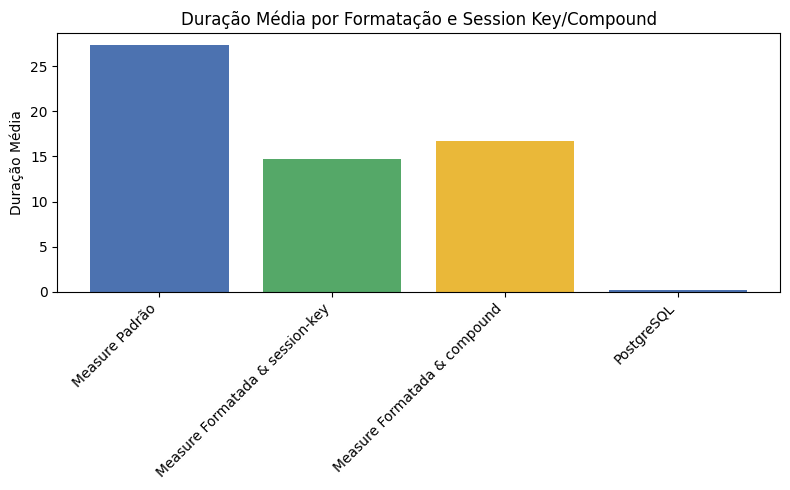

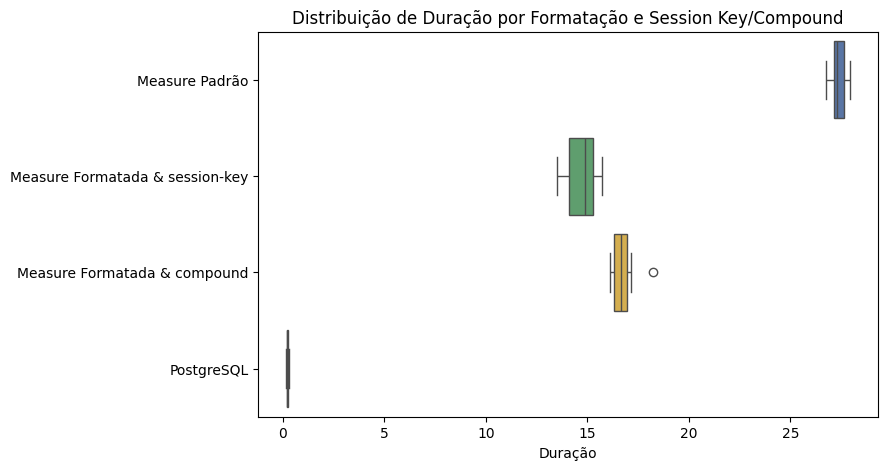

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

means = {
    "Measure Padrão": sum(results_raw_data) / len(results_raw_data),
    "Measure Formatada & session-key": sum(results_new_format_session_key) / len(results_new_format_session_key),
    "Measure Formatada & compound": sum(results_new_format_compund) / len(results_new_format_compund),
    "PostgreSQL": sum(best_results_postgres) / len(best_results_postgres),
}

# Gráfico de Barras (Médias)
plt.figure(figsize=(8, 5))
plt.bar(means.keys(), means.values(), color=["#4C72B0", "#55A868", "#EAB839"])
plt.title("Duração Média por Formatação e Session Key/Compound")
plt.ylabel("Duração Média")
plt.xticks(rotation=45, ha='right') 
plt.tight_layout()
plt.show()

# Box Plot Horizontal
plt.figure(figsize=(8, 5))
sns.boxplot(data=[results_raw_data, results_new_format_session_key, results_new_format_compund, best_results_postgres], 
            palette=["#4C72B0", "#55A868", "#EAB839", "#EAB839"], orient="h")
plt.yticks([0, 1, 2, 3], ["Measure Padrão", "Measure Formatada & session-key", "Measure Formatada & compound", "PostgreSQL"])
plt.title("Distribuição de Duração por Formatação e Session Key/Compound")
plt.xlabel("Duração")
plt.show()